# Prefit Ys

Substitute $Y_{obs}$ and $Y_{unobs}$ with a single $Y$ parameter whose $\mu$ and $\sigma$ are initialized to fits from the background distribution for that gene.

# Inputs

In [7]:
import rnaseq_lib3 as r
import pandas as pd
import scipy.stats as st
import pymc3 as pm
import numpy as np
import time
import os
from tqdm import tqdm_notebook as tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read in centered data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt.hd5')
# Subset
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal'].sort_values('tissue')
tumor = df[df.label == 'tcga-tumor'].sort_values('tissue')
# Read in drug genes
genes = df.columns[5:]
drug_genes = [x.split('\t')[0] for x in open('../../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

## Distribution Fit Example

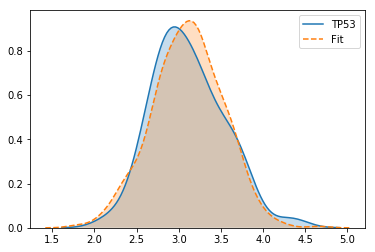

In [7]:
gene = 'TP53'
gene_dist = normal[normal.tissue == 'Liver']['TP53']
sns.kdeplot(gene_dist, label=gene, shade=True)
loc, scale = st.norm.fit(gene_dist)
sns.kdeplot(st.norm.rvs(loc=loc, scale=scale, size=1000), label='Fit', shade=True, ls='--');

# Model Spec
Define inputs to model
- Sample
- Background dataset
- Training Genes

In [3]:
sample = tumor.loc['TCGA-FY-A3I4-01']
print(f"Sample comes from tissue: {sample.tissue}")
# We'll pick a subset of normal tissue for model training
test = normal[normal.tissue.isin(['Thyroid', 'Prostate', 'Kidney', 'Liver'])]
training_genes = r.outlier.select_k_best_genes(test, genes, 'tissue', 50)
classes = sorted(test.tissue.unique())
ncats = len(classes)
print(f'{ncats} background datasets and {len(training_genes)} genes')

Sample comes from tissue: Thyroid
4 background datasets and 50 genes


Define Model

In [30]:
with pm.Model() as model:
    # PRIORS
    a =  pm.Normal('a', mu=0, sd=10)
    # Beta Coefficient
    mu_b = pm.Normal('mu_b', mu=0, sd=10)
    sigma_b = pm.InverseGamma('sigma_b', 2.1, 1)
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=ncats)
    
    # Means
    ys = {}
    mu = {}
    fits = {}
    idx = test.tissue.astype('category').cat.codes
    for gene in training_genes:
        for dataset in classes:
            cat_mu, cat_sd = st.norm.fit(test[test.tissue == dataset][gene])
            # Standard deviation can't be initialized to 0, so set to 0.1
            cat_sd = 0.1 if cat_sd == 0 else cat_sd
            name = f'{gene}-{dataset}'
            ys[name] = pm.Normal(name, cat_mu, cat_sd)
        
        # Define mu
        mu[gene] = a
        for i, dataset in enumerate(classes):
            mu[gene] += b[i] * ys[f'{gene}-{dataset}']
    
    # Model estimation
    eps = pm.InverseGamma('eps', 2.1, 1)
    z = {}
    for gene in training_genes:
        z[gene] = pm.Laplace(gene, mu=mu[gene], b=eps, observed=sample[gene])

# Run Model

In [13]:
t0 = time.time()
with model:
    trace = pm.sample()
runtime = (time.time() - t0) / 60

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, C3P1-Thyroid, C3P1-Prostate, C3P1-Liver, C3P1-Kidney, GYS2-Thyroid, GYS2-Prostate, GYS2-Liver, GYS2-Kidney, SLCO1B1-Thyroid, SLCO1B1-Prostate, SLCO1B1-Liver, SLCO1B1-Kidney, SLC10A1-Thyroid, SLC10A1-Prostate, SLC10A1-Liver, SLC10A1-Kidney, LECT2-Thyroid, LECT2-Prostate, LECT2-Liver, LECT2-Kidney, F9-Thyroid, F9-Prostate, F9-Liver, F9-Kidney, OTC-Thyroid, OTC-Prostate, OTC-Liver, OTC-Kidney, CPN1-Thyroid, CPN1-Prostate, CPN1-Liver, CPN1-Kidney, C9-Thyroid, C9-Prostate, C9-Liver, C9-Kidney, UGT1A4-Thyroid, UGT1A4-Prostate, UGT1A4-Liver, UGT1A4-Kidney, C8A-Thyroid, C8A-Prostate, C8A-Liver, C8A-Kidney, PGLYRP2-Thyroid, PGLYRP2-Prostate, PGLYRP2-Liver, PGLYRP2-Kidney, SERPINA7-Thyroid, SERPINA7-Prostate, SERPINA7-Liver, SERPINA7-Kidney, SERPINA10-Thyroid, SERPINA10-Prostate, SERPINA10-Liver, SERPINA10-Kidney, GCKR-Thyroid, GCKR-Prostate, GCKR-Liver, GCKR-Kidney,

# Traceplot

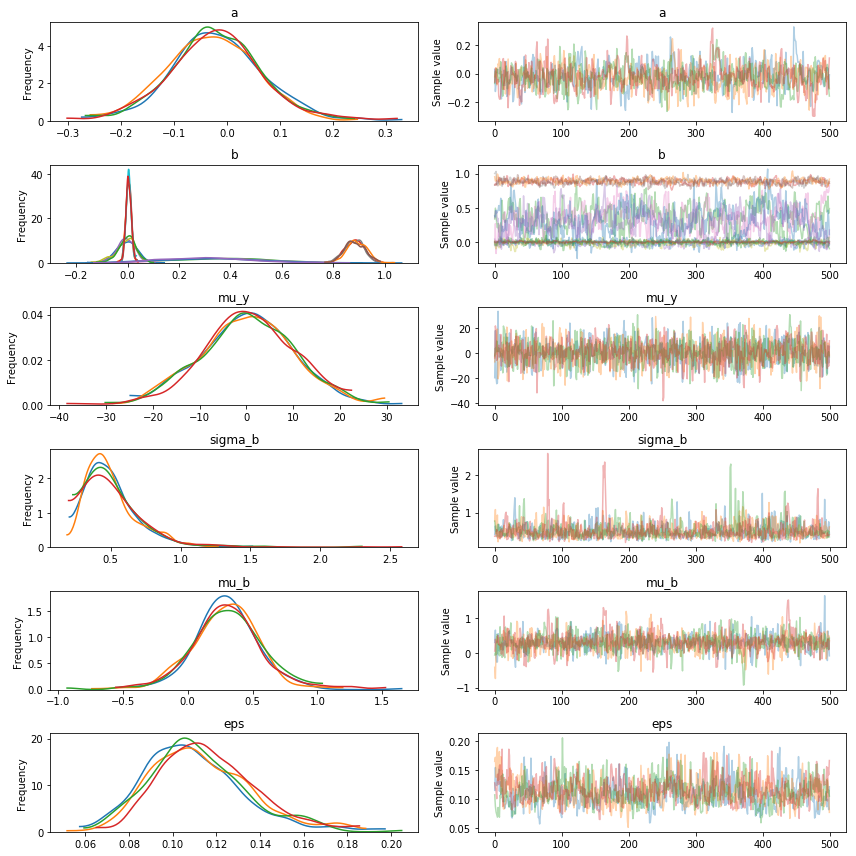

In [14]:
pm.traceplot(trace, varnames=['a', 'b', 'mu_y', 'sigma_b', 'mu_b', 'eps']);

# Model Weight

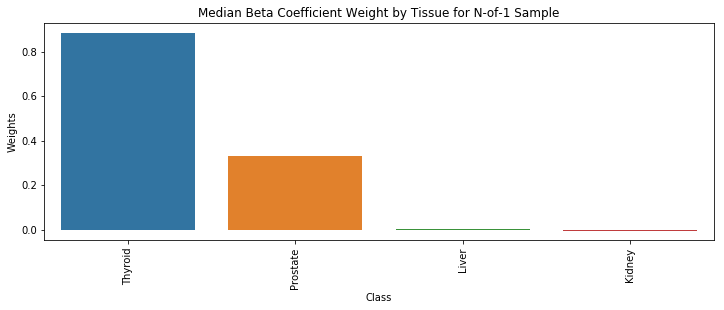

In [15]:
r.outlier.plot_weights(classes, trace)

# PPC

In [16]:
ppc = pm.sample_ppc(trace, model=model)

100%|██████████| 500/500 [00:25<00:00, 19.96it/s]


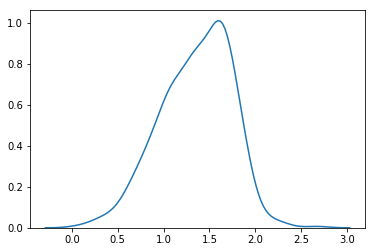

In [18]:
sns.kdeplot(ppc['HP'])

In [24]:
trace['HP-Liver'].shape

(2000,)

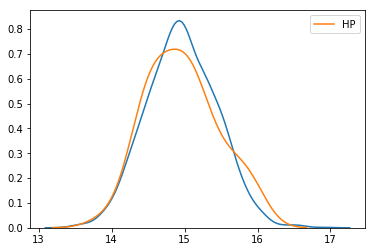

In [26]:
sns.kdeplot(trace['HP-Liver'])
sns.kdeplot(normal[normal.tissue == 'Liver']['HP'])

# Run Model With All Normals

## Model Spec and Definition

In [4]:
test = normal
training_genes = r.outlier.select_k_best_genes(test, genes, 'tissue', 50)
classes = sorted(test.tissue.unique())
ncats = len(classes)
print(f'{ncats} background datasets and {len(training_genes)} genes')

20 background datasets and 50 genes


In [5]:
with pm.Model() as model_normal:
    # Linear model priors
    a =  pm.Normal('a', mu=0, sd=10)
    mu_b = pm.Normal('mu_b', mu=0, sd=10)
    sigma_b = pm.InverseGamma('sigma_b', 2.1, 1)
    b = pm.LogitNormal('b', mu=mu_b, sd=sigma_b, shape=ncats)
    # Model error
    eps = pm.InverseGamma('eps', 2.1, 1)
    
    # Linear model declaration
    for gene in tqdm(training_genes):
        mu = a
        for i, dataset in enumerate(classes):
            cat_mu, cat_sd = st.norm.fit(test[test.tissue == dataset][gene])
            # Standard deviation can't be initialized to 0, so set to 0.1
            cat_sd = 0.1 if cat_sd == 0 else cat_sd
            name = f'{gene}-{dataset}'
            y = pm.Normal(name, cat_mu, cat_sd)
            mu += b[i] * y
        
        # Embed mu in laplacian distribution
        pm.Laplace(gene, mu=mu, b=eps, observed=sample[gene])

## Run Model

In [8]:
t0 = time.time()
out_path = os.path.join('/mnt/research_serializations/Prefit-Ys', f'{sample.id}-normal-50G.pkl')
if os.path.exists(out_path):
    pkl = pickle.load(open(out_path, 'rb'))
    trace_normal, model_normal = pkl['normal'], pkl['model']
else:
    with model_normal:
        trace_normal = pm.sample()
    runtime = (time.time() - t0) / 60 / 60
    print(f"Runtime: {runtime} hours")
    pkl = {}
    pkl['trace'], pkl['model'] = trace_normal, model_normal
    with open(out_path, 'wb') as f:
        pickle.dump(pkl, f)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PSMB11-Uterus, PSMB11-Thyroid, PSMB11-Thymus, PSMB11-Stomach, PSMB11-Soft_tissue, PSMB11-Skin, PSMB11-Prostate, PSMB11-Pancreas, PSMB11-Lung, PSMB11-Liver, PSMB11-Kidney, PSMB11-Head, PSMB11-Esophagus, PSMB11-Colon, PSMB11-Cervix, PSMB11-Breast, PSMB11-Brain, PSMB11-Bladder, PSMB11-Bile, PSMB11-Adrenal, GBP7-Uterus, GBP7-Thyroid, GBP7-Thymus, GBP7-Stomach, GBP7-Soft_tissue, GBP7-Skin, GBP7-Prostate, GBP7-Pancreas, GBP7-Lung, GBP7-Liver, GBP7-Kidney, GBP7-Head, GBP7-Esophagus, GBP7-Colon, GBP7-Cervix, GBP7-Breast, GBP7-Brain, GBP7-Bladder, GBP7-Bile, GBP7-Adrenal, SLC22A9-Uterus, SLC22A9-Thyroid, SLC22A9-Thymus, SLC22A9-Stomach, SLC22A9-Soft_tissue, SLC22A9-Skin, SLC22A9-Prostate, SLC22A9-Pancreas, SLC22A9-Lung, SLC22A9-Liver, SLC22A9-Kidney, SLC22A9-Head, SLC22A9-Esophagus, SLC22A9-Colon, SLC22A9-Cervix, SLC22A9-Breast, SLC22A9-Brain, SLC22A9-Bladder, SLC22A9-Bi

Sampling 4 chains: 100%|██████████| 4000/4000 [8:04:11<00:00, 30.62s/draws]  
The acceptance probability does not match the target. It is 0.39192638191160434, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.906715437250192, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Runtime: 11.856045090622372 hours


NameError: name 'pickle' is not defined

## Traceplot

In [ ]:
pm.traceplot(trace_normal, varnames=['a', 'b', 'mu_y', 'sigma_b', 'mu_b', 'eps']);

## Model Weight

In [ ]:
r.outlier.plot_weights(classes, trace_normal)

## PPC

In [ ]:
ppc = pm.sample_ppc(trace_normal, model=model_normal)

In [ ]:
gene = 'SFTPC'
plt.axvline(sample[gene], label='N-of-1', c='r')
sns.kdeplot(normal[normal.tissue == 'Thyroid'][gene], label='Thyroid')
sns.kdeplot(trace_normal[f'{gene}-Thyroid'], label=f'Y-{gene}-Thyroid')
sns.kdeplot(ppc[gene], label='PPC')
sns.kdeplot(z, label='PPC-Calculated')
plt.title(f'Prefit-Y Distributions for {gene}')

We can see the model takes our prefit-$Y$s and drastically shifts the $\mu$ as the model trains (blue -> orange). This causes the mean of the PPC to almost always center around our n-of-1 sample. 